# Predicting Formula 1 Performance in Track and Weather Data 

**Group:** V10FTW  
**Members:** Oskar Floeck s3725028 & Connor Hutchinson s3544152

## Table of Contents

* [Source and Description](#desc)
* [Goals and Objectives](#goals)
* [Data Preparation](#data)
* [Data Exploration](#explore)
* [Statistical Modelling & Performance Evaluation](#model)
* [Summary & Conclusion](#conc)

## Source and Description <a name="desc">

**Track Data**: https://ergast.com/mrd (Ergast, 2020)  
**Weather Data**: https://www.motorsport-total.com/formel-1/ergebnisse (Motorsport-total, 2020)

Given the way in which weather data was provided by the website above, a script was written to automatically grab neccesary information and store within `track_weather.csv` for analysis in this report. The full script can be [viewed here](https://github.com/floeck/f1-weather-analysis/blob/master/notebooks/scrape-weather.ipynb).

* `races.csv` and `results.csv` obtained from Ergast: Contain all the relevant track data, such as fastest lap speeds, times and date.

* `track_weather.csv` from motorsport-total: Contain track weather information, such as humidity etc.

For the purposes of the report and due to track weather scraping limitations, the following tracks will be used in the analysis from the year 2007 to 2019. Details of these limitations are viewable on the script.

<table>
<tr>
</tr>
<tr>
<td>
    
* Albert Park, Australia
* Sepang, Malaysia
* Sachir, Bahrain
* Catalunya, Spain
* De Monaco, Europe 
* Montreal, Canada
* Magny Cours, France
* Silverstone, Britain
* Valencia, Germany
* Hungaroring, Hungary 
    
</td>
<td>
    
* Istanbul, Turkey
* Monza, Italy
* De Spa, Belgium
* Fuji, Japan
* Shanghai, China
* Interlagos, Brazil
* Yas Marina, Abu Dhabi
* Indianapolis, America
* Austin, America
* Hermanos, Mexico
    
</td>
</tr>
</table>

### Descriptive Features

Descriptions of data for `races.csv`

| feature | type  | units  | desc  |
|---|---|---|---|
| raceId  | ordinal | unknown | ID of the race |
| name | categorical | unknown  | Name of the race |
| date | date | yyyy-mm-dd | Date of race |

Descriptions of data for `results.csv`

| feature | type  | units  | desc  |
|---|---|---|---|
| raceId  | ordinal | unknown | ID of the race |
| fastestLapTime | positive real number | milliseconds  | Fastest lap time |

Descriptions of data for `track_weather.csv`

| feature | type  | units  | desc  |
|---|---|---|---|
| track  | categorical | unknown | Track name |
| date | date | yyyy-mm-dd | Date of race |
| local_time | time | hh:mm:ss | Time of race |
| weather | categorical | unknown | Track conditions |
| temp | positive real number | celcius | Ambient temp |
| track_temp | positive real number | celcius | Track temp |
| humidity | positive real number | % | Ambient humidity |
| air_pressure | positive real number | mBar | Ambient air pressure |
| wind_speed | positive real number | m/s | Track wind speed |
| wind_direction | categorical | direction | Track wind direction |


### Target Feature
The target feature is `fastestLapTime` which is a continuous numerical feature.

## Goals and Objectives

The primary goal of the report is to investigate whether or not we can accurately and reliably predict Formula 1 lap times via multiple linear regression, given the weather and track data we have collected. Secondary goals are investigating the effects weather may have on general track performance. We hypothesise track temps and rain to most significantly influence performance.

## Data Preparation

### Preliminaries

First, import all necessary modules required for the analysis.

In [147]:
# Module imports
import warnings; import patsy; import matplotlib
import pandas as pd; import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
# Disable warnings and allow large columns
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
matplotlib.rcParams['figure.figsize'] = (20, 16)
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams.update({'font.size': 22})
%matplotlib inline
# Function that allows to convert time
def to_milliseconds(string):
    string = string.replace(".", ":").split(":")
    minutes = int(string[0])
    seconds = int(string[1])
    milliseconds = int(string[2])
    return (minutes * 60000) + (seconds * 1000) + milliseconds

Here we read in the data directly from the repository site.

In [148]:
races = pd.read_csv('https://raw.githubusercontent.com/floeck/f1-weather-analysis/master/data/formula-1/races.csv', sep = ',')
results = pd.read_csv('https://raw.githubusercontent.com/floeck/f1-weather-analysis/master/data/formula-1/results.csv', sep=',')
track_weather = pd.read_csv('https://raw.githubusercontent.com/floeck/f1-weather-analysis/master/data/weather/track_weather.csv', sep=',')

In [149]:
races.sample(5, random_state=999)

,raceId,year,round,circuitId,name,date,time,url
685,686,1967,8,48,Canadian Grand Prix,1967-08-27,\N,http://en.wikipedia.org/wiki/1967_Canadian_Gra...
117,118,2003,11,9,British Grand Prix,2003-07-20,\N,http://en.wikipedia.org/wiki/2003_British_Gran...
160,161,2000,4,9,British Grand Prix,2000-04-23,\N,http://en.wikipedia.org/wiki/2000_British_Gran...
729,730,1962,2,6,Monaco Grand Prix,1962-06-03,\N,http://en.wikipedia.org/wiki/1962_Monaco_Grand...
94,95,2004,6,6,Monaco Grand Prix,2004-05-23,\N,http://en.wikipedia.org/wiki/2004_Monaco_Grand...


In [150]:
results.sample(5, random_state=999)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
20959,20962,848,5,205,20,19,19,19,19,0.0,55,\N,\N,44,19,1:45.055,185.697,12
24036,24042,1001,807,4,27,20,\N,R,20,0.0,0,\N,\N,\N,0,\N,\N,3
6593,6594,308,138,25,3,11,\N,R,20,0.0,35,\N,\N,\N,\N,\N,\N,20
5388,5389,266,50,22,6,12,3,3,3,4.0,77,+1:10.329,6550514,\N,\N,\N,\N,1
1691,1692,98,13,15,12,15,\N,R,18,0.0,0,\N,\N,\N,\N,\N,\N,4


In [151]:
track_weather.sample(5, random_state=999)

,track,date,local_time,weather,temp,track_temp,humidity,air_pressure,wind_speed,wind_direction
96,austin,2012-11-18,13:00:00,sunny,24.0,32.0,29.0,1004.0,5.0,south
245,abu-dhabi,2018-11-25,17:10:00,"clear, short showers",29.0,31.0,55.0,1014.0,3.5,turning southeast
68,montreal,2010-06-13,12:00:00,slightly cloudy,26.0,38.0,42.0,1011.0,3.0,northeast
162,istanbul,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,indianapolis,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning and Transformation

Now that all the data is imported, we can begin cleaning and remove unneccesary information.

In [152]:
# Drop unneccesary columns
races = races.drop(columns = ['year', 'circuitId', 'round', 'time', 'url'])
results = results.drop(columns = ['resultId', 'driverId', 'constructorId', 'number', 'grid', 'position',
                                  'positionText', 'positionOrder', 'points', 'laps', 'fastestLap', 'time',
                                  'milliseconds', 'fastestLap', 'rank', 'statusId', 'fastestLapSpeed'])
track_weather = track_weather.drop(columns = 'local_time')
# Update problem data in columns
results = results.replace(r'\\N','null', regex=True)
# Query only those with races finishes
results = results.loc[results['fastestLapTime'] != 'null']
# Rename lap time column
results.rename(columns={'fastestLapTime': 'lapTime'}, inplace = True)
# Convert fastest time to milliseconds
results['lapTime'] = results['lapTime'].apply(to_milliseconds)
# Group by track and date, then average lap and average speed
races_results = races.merge(results, on = 'raceId').groupby(['raceId', 'name', 'date']).mean()
df = races_results.merge(track_weather, on = 'date')
# Add rain column
rain_desc = ["rain", "shower", "drizzle", "wet"]
df['rain'] = np.where(df['weather'].str.contains('|'.join(rain_desc)), 'wet', 'dry')
# Round & export dataframe to csv
df = df.round(3)
df.to_csv('../data/V10FTW_Data.csv')
#Now lets have a look to see our dataframe features match the description outlined earlier in the report.
print(f"Shape of the dataset is {df.shape} \n")
print(df.dtypes)

Shape of the dataset is (215, 11) 

date               object
lapTime           float64
track              object
weather            object
temp              float64
track_temp        float64
humidity          float64
air_pressure      float64
wind_speed        float64
wind_direction     object
rain               object
dtype: object


### Check for Missing Values

In [153]:
print(f"\nMissing values for each feature:"); print(df.isnull().sum())


Missing values for each feature:
date              0
lapTime           0
track             0
weather           0
temp              0
track_temp        0
humidity          0
air_pressure      0
wind_speed        0
wind_direction    0
rain              0
dtype: int64


Lets take a quick peak at how our dataframe is looking.

In [154]:
df.head()

,date,lapTime,track,weather,temp,track_temp,humidity,air_pressure,wind_speed,wind_direction,rain
0,2009-03-29,88833.158,albert-park,sunny,21.0,27.0,65.0,1020.0,5.0,south,dry
1,2009-04-05,98636.611,sepang,"sunny, then rain",27.0,32.0,86.0,1006.0,5.0,turning,wet
2,2009-04-19,114742.650,shanghai,rain,20.0,18.0,90.0,1003.0,4.5,east,wet
3,2009-04-26,95438.900,sachir,sunny,36.0,49.0,18.0,1005.0,4.0,east,dry
4,2009-05-10,83960.500,catalunya,slightly cloudy,24.0,42.0,54.0,1000.0,2.0,southeast,dry


### Summary Statistics
Here we can view a summary of the continuous and categorical variables.

In [155]:
df.describe(include='float64')

,lapTime,temp,track_temp,humidity,air_pressure,wind_speed
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,92600.561456,24.074419,35.190698,51.269767,987.548837,2.922326
std,11098.117244,5.040402,9.345193,16.970061,72.822125,1.644096
min,72460.200000,12.000000,14.000000,5.000000,99.000000,0.600000
25%,83092.395500,20.500000,29.000000,40.000000,991.000000,1.500000
50%,92599.222000,24.000000,34.000000,50.000000,1003.000000,2.500000
75%,100946.418000,27.500000,42.000000,61.000000,1012.000000,4.000000
max,121779.435000,37.000000,60.000000,98.000000,1025.000000,8.000000


Now specifically investigating the target feature of our report, namely `lapTime`. Range of `lapTime` seems suitable, as does its variance.

In [156]:
df.describe(include='object')

,date,track,weather,wind_direction,rain
count,215,215,215,215,215
unique,206,20,34,16,2
top,2012-11-18,fuji,sunny,south,dry
freq,2,13,83,31,182


### Continuous Features

Testing for potential multicollinearity problems that may effect our models performance.

In [158]:
df.corr(method='spearman')

,lapTime,temp,track_temp,humidity,air_pressure,wind_speed
lapTime,1.000000,-0.052734,-0.356947,0.160068,0.138620,0.187672
temp,-0.052734,1.000000,0.616918,-0.318113,0.073936,-0.116751
track_temp,-0.356947,0.616918,1.000000,-0.472892,-0.082002,-0.205659
humidity,0.160068,-0.318113,-0.472892,1.000000,-0.076109,0.078590
air_pressure,0.138620,0.073936,-0.082002,-0.076109,1.000000,-0.029121
wind_speed,0.187672,-0.116751,-0.205659,0.078590,-0.029121,1.000000


This information may be more interpretable later on when we develop our models for `lapTime`. On first glance, it seems `air_pressure` is going to have little predictive power, due to its low range and lack of relationship with other features. Additionally, `temp` and `track_temp` seem closely related, as expected.

### Categorical Features

We can now safely remove the `date` and `weather` columns as `rain` describes the track conditions, and `date` was used only to confirm independent races.

In [159]:
df = df.drop(columns=['date', 'weather'])

Now lets investigate the categorical features of our dataframe.

In [160]:
categorical_columns = df.columns[df.dtypes==object].tolist()
for col in categorical_columns:
    print('Unique values: ' + col)
    print(df[col].unique()); print('')

Unique values: track
['albert-park' 'sepang' 'shanghai' 'sachir' 'catalunya' 'de-monaco'
 'istanbul' 'silverstone' 'hungaroring' 'valencia' 'de-spa' 'monza' 'fuji'
 'interlagos' 'abu-dhabi' 'montreal' 'magny-cours' 'indianapolis' 'austin'
 'mexico']

Unique values: wind_direction
['south' 'turning' 'east' 'southeast' 'northeast' 'northwest' 'west'
 'north' 'southern' 'southwest' 'turning east' 'turning south'
 'western liqueur' 'turning west' 'turning southeast' 'changing']

Unique values: rain
['dry' 'wet']



As shown above, the unique values for `wind_direction` are less uniform than expected. Due to a translator function being used in the scrape weather script mentioned earlier, there is some irregular information being shown (e.g. changing, western liqueur, turning west). With this in mind, it is likely that this data is not going to be useful in our models. Therefore, it will be removed.

In [161]:
df = df.drop(columns='wind_direction')

## Data Exploration <a name="explore">

We will now explore and investigate our data that we have prepared before modelling.

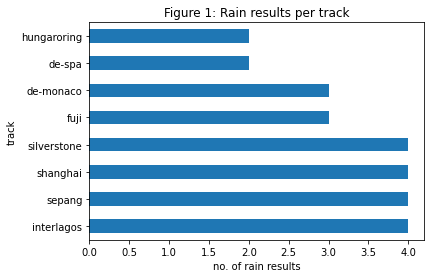

In [162]:
#Compare dry vs wet laptimes at one circuit vs another
wet = df.loc[(df['rain'] == 'wet')]; value_counts = wet['track'].value_counts().head(8).plot(kind='barh')
#only showing top 8 results for simplicity
plt.title('Figure 1: Rain results per track'); plt.ylabel('track'); plt.xlabel('no. of rain results');plt.show()

Figure 2: Laptimes at various tracks in wet and dry conditions


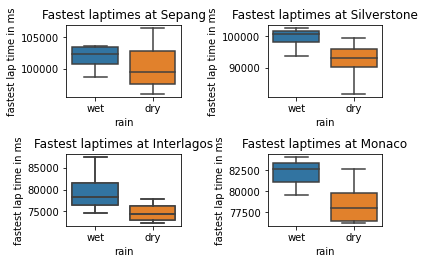

In [163]:
#Figure setup
print("Figure 2: Laptimes at various tracks in wet and dry conditions")
fig = plt.figure()
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222); ax3 = fig.add_subplot(223); ax4 = fig.add_subplot(224)
silverstone = df[df['track']=='silverstone']; sepang = df[df['track']=='sepang']
interlagos = df[df['track']=='interlagos']; deMonaco = df[df['track']=='de-monaco']
interlagosTimes = sns.boxplot(y="lapTime",x="rain",data=interlagos.sort_values(by='rain',ascending=False),ax=ax3)
interlagosTimes.set(ylabel="fastest lap time in ms",title='Fastest laptimes at Interlagos')
sepangTimes = sns.boxplot(y="lapTime",x="rain",data=sepang.sort_values(by='rain',ascending=False),ax=ax1)
sepangTimes.set(ylabel="fastest lap time in ms",title="Fastest laptimes at Sepang")
silverstoneTimes = sns.boxplot(y="lapTime",x="rain",data=silverstone.sort_values(by='rain',ascending=False),ax=ax2)
silverstoneTimes.set(ylabel="fastest lap time in ms",title='Fastest laptimes at Silverstone')
interlagosTimes = sns.boxplot(y="lapTime",x="rain",data=interlagos.sort_values(by='rain',ascending=False),ax=ax3)
interlagosTimes.set(ylabel="fastest lap time in ms",title='Fastest laptimes at Interlagos')
monacoTimes = sns.boxplot(y="lapTime",x="rain",data=deMonaco.sort_values(by='rain',ascending=False),ax=ax4)
monacoTimes.set(ylabel="fastest lap time in ms",title='Fastest laptimes at Monaco')
plt.tight_layout(pad=2, w_pad=2, h_pad=1); plt.show()

In the above comparison, Sepang, Interlagos and Silverstone (3 of the tracks with the highest quantity of wet races, likely due to their natural climates) show that wet tracks can have a general increase on laptimes (as expected). However, this also shows that there are some outliers and external factors other than rain that can affect these lengthier times. Those anomolies (on both wet and dry) are likely due to either severe weather or safety factors. All of them do however show that it is incredibly unlikely to get the fastest possible laptime in wet conditions.
There is however some extremely impressive lap times in all of the above results given that the max whisker (in all graphs) sits in the interquartile range of the dry lap times.

### Temperature

Comparing the above tracks and the affect that temps have on the laptimes.

First however, a quick overview of the above track temperature and their normal distributions at each track. This will help give us an overview of the differences in the track temps at each track as well as just how much the track temps can differ over a variety of races on a given track.

Figure 3: Track temps investigation


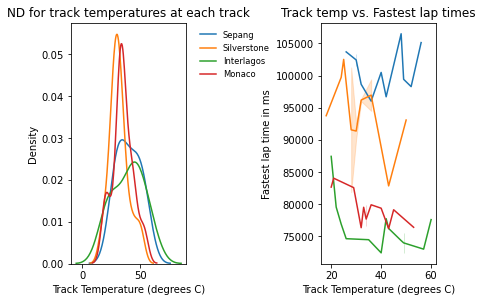

In [164]:
#Figure setup
print("Figure 3: Track temps investigation")
fig = plt.figure(); ax = fig.add_subplot(121); ax1 = fig.add_subplot(122)
sns.distplot(sepang[['track_temp']],hist=False,ax=ax,label='Sepang')
sns.distplot(silverstone[['track_temp']],hist=False,ax=ax,label='Silverstone')
sns.distplot(interlagos[['track_temp']],hist=False,ax=ax,label='Interlagos')
sns.distplot(deMonaco[['track_temp']],hist=False,ax=ax,label='Monaco')
ax.set_title('ND for track temperatures at each track')
ax.set_xlabel('Track Temperature (degrees C)'); ax.set_ylabel('Density')
ax.legend(loc='best',frameon=False, bbox_to_anchor=(1.05, 1), fontsize='small')
sns.lineplot(x="track_temp",y="lapTime",data=sepang)
sns.lineplot(x="track_temp",y="lapTime",data=silverstone)
sns.lineplot(x="track_temp",y="lapTime",data=interlagos)
sns.lineplot(x="track_temp",y="lapTime",data=deMonaco)
plt.title('Track temp vs. Fastest lap times')
plt.xlabel('Track Temperature (degrees C)'); plt.ylabel('Fastest lap time in ms')
plt.tight_layout(pad=0, w_pad=3, h_pad=1); plt.show()

Before continuing, it is worth noting that this shows that Silverstone is the most left skewed of 40deg, meaning that it generally will be cooler on that track compared to the others. Interlagos has a much broader spread however appears to be generally the hotter track.
Although a relationship cannot be made over all tracks, a general decrease in lap times can be seen over Interlagos, Silverstone and Monaco when track temps increase. This is suggestive that warmer tracks can play a role in reducing lap times. However, with with the exception of Monaco's results, all show that there is a threshold where high track temps can cause a spike in fastest lap times to increase. Track temps are generally hotter than the air temperature and can result in better grip, however too high can potentially degrade tyres much faster. 
<br>Overall it is clearly not as major a factor to lap performance as wet weather was in our previous graphs, however it was worth noting the relationship.

### Wind Speed

Finally, in regards to weather, we will look at the affects of wind speeds on F1 performance.

Figure 4: Wind speed investigation


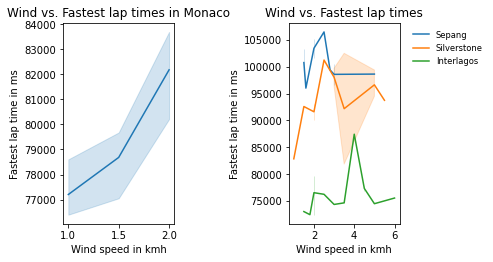

In [165]:
#Figure setup
print("Figure 4: Wind speed investigation")
fig = plt.figure()
ax1 = fig.add_subplot(121)
sns.lineplot(x="wind_speed",y="lapTime",data=deMonaco)
plt.title('Wind vs. Fastest lap times in Monaco')
plt.xlabel('Wind speed in kmh'); plt.ylabel('Fastest lap time in ms')
ax2 = fig.add_subplot(122)
sns.lineplot(x="wind_speed",y="lapTime",data=sepang,label="Sepang")
sns.lineplot(x="wind_speed",y="lapTime",data=silverstone,label="Silverstone")
sns.lineplot(x="wind_speed",y="lapTime",data=interlagos,label="Interlagos")
plt.title('Wind vs. Fastest lap times')
plt.xlabel('Wind speed in kmh'); plt.ylabel('Fastest lap time in ms')
plt.tight_layout(pad=2, w_pad=2, h_pad=1)
plt.legend(loc='best',frameon=False, bbox_to_anchor=(1.05, 1), fontsize='small'); plt.show()

In the above we have seperated Monaco due to its unique lower average wind speed. We can clearly see that Monaco generally has quite low wind speeds across all of its results, ranging from as little as 1 to 2kmh. This may be consistent with Monaco being one of the few street circuits in Formula 1, hosted mainly around the streets of Monte Carlo. Both graphs show quite linear results in Monaco, where a slight increase in wind speeds results in longer laptimes. However, the results presented across the other circuits is not quite as consistent.<br>
To us, this suggests that wind speeds, when isolated and low, present a reasonably large impact on lap performance. However, across tracks that are more susceptible to higher wind speeds and other enviornmental factors due to being more open than Monaco, results can be messy and a relationship being made is inconclusive.
<br>
To investigate further, we will now look at the likelyhood of having multiple instances of the above weather and how likely it is that they will occur.

### Multiple Weather Events

Figure 5: Multiple weather events


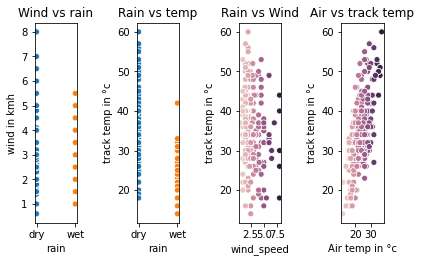

In [166]:
# create scatterplot 
print("Figure 5: Multiple weather events")
fig = plt.figure()
ax1 = fig.add_subplot(141); ax2 = fig.add_subplot(142); ax3 = fig.add_subplot(143); ax4 = fig.add_subplot(144)
rain_wind = sns.scatterplot(df['rain'], df['wind_speed'], hue=df['rain'],ax=ax1)
rain_wind.set(title='Wind vs rain',ylabel='wind in kmh')
rain_temp = sns.scatterplot(df['rain'], df['track_temp'], hue=df['rain'],ax=ax2)
rain_temp.set(title='Rain vs temp',ylabel='track temp in \N{DEGREE SIGN}c')
wind_temp = sns.scatterplot(df['wind_speed'], df['track_temp'], hue=df['wind_speed'],ax=ax3)
wind_temp.set(title='Rain vs Wind',ylabel='track temp in \N{DEGREE SIGN}c')
air_tracktemp = sns.scatterplot(df['temp'],df['track_temp'], hue=df['temp'],ax=ax4)
air_tracktemp.set(title='Air vs track temp',ylabel="track temp in \N{DEGREE SIGN}c", xlabel="Air temp in \N{DEGREE SIGN}c")
ax1.get_legend().remove(); ax2.get_legend().remove(); ax3.get_legend().remove(); ax4.get_legend().remove()
plt.tight_layout(pad=2, w_pad=2, h_pad=1); plt.show();

Thanks to the above, we can conclude that wind and rain, and wind and temperature are independent from one another. However, it seems that for the majority, higher recorded track temps are commonly on dry days.
This also provides us backup in regards to not including other factors in our data. Such as the 4th graph showing track vs air temperature being very closely related, where an increase in air temp results in an increase of recorded track temperatures.
<br><br>

## Statistical Modelling & Performance Evaluation <a name="model">

### Full Model
Below is our current dataframe we will be using to develop our models for predicting `lapTime`.

In [168]:
df.head()

,lapTime,track,temp,track_temp,humidity,air_pressure,wind_speed,rain
0,88833.158,albert-park,21.0,27.0,65.0,1020.0,5.0,dry
1,98636.611,sepang,27.0,32.0,86.0,1006.0,5.0,wet
2,114742.650,shanghai,20.0,18.0,90.0,1003.0,4.5,wet
3,95438.900,sachir,36.0,49.0,18.0,1005.0,4.0,dry
4,83960.500,catalunya,24.0,42.0,54.0,1000.0,2.0,dry


On the X-Axis, we add all of our features and categorical variables. Below are the categorical features that will be converted and first dropped for our model. `track` is included in the model as a categorical variable as each track requires different car configurations and differs in distance etc.
* `rain` dummy dropped is condition dry
* `track` dummy dropped is track Abu-Dahbi

On the Y-Axis, our target features mentioned earlier, namely `lapTime`.

In [181]:
X = df[['temp', 'track_temp', 'humidity', 'air_pressure', 'wind_speed', 'rain', 'track']]
Y = df['lapTime']
X = pd.get_dummies(data=X, drop_first=True)
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                lapTime   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     38.16
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           1.40e-60
Time:                        16:19:07   Log-Likelihood:                -2113.7
No. Observations:                 215   AIC:                             4279.
Df Residuals:                     189   BIC:                             4367.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.065e+05   7103

#### Model Analysis

Adj. R-squared is 0.813, which means 81.3% of the variation is explained by the independant variables. Observing the p-values, `wind_speed` and `rain_wet` are statistically significant at the 5% level, whereas `temp`, `track_temp`, `humidity`, and `air_pressure` are not. Most of the `tracks` are highly significant, bar a few.

Now we produce new dataframes for prediction purposes, and plot residuals for the mull models.

In [183]:
residuals_full = pd.DataFrame({'actual': df['lapTime'], 'predicted': model.fittedvalues, 'residual': model.resid})
residuals_full.sample(5, random_state=999)

,actual,predicted,residual
148,101203.545,102269.971459,-1066.426459
191,84167.789,87247.777256,-3079.988256
125,103112.500,100498.847948,2613.652052
68,91556.087,90745.401566,810.685434
187,95886.722,85422.974377,10463.747623


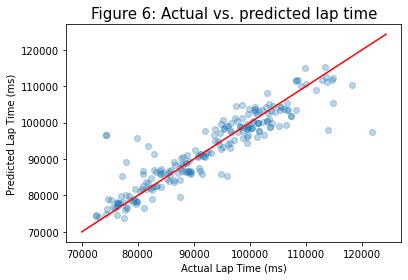

In [184]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
plt.scatter(residuals_full['actual'], residuals_full['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Lap Time (ms)');
plt.ylabel('Predicted Lap Time (ms)');
plt.title('Figure 6: Actual vs. predicted lap time', fontsize=15);plt.show();

As above in Figure 6, we observe that on shorter tracks <85000ms variation is quite high, however the bulk of the data remains fairly even. Similar on tracks above lap times of >110000ms. An assumption here is that the longer the track time, the larger the total distance of the track.

### Model Diagnostic Checks

This section of the report will analyse assumptions of our regression, and whether or not they are sound. More noteably:
* Linearity of relationship between target variables and independant variables
* Constant variance of errors
* Normality of residual distribution
* Statistical independence of residuals

First, lets produce a scatter plot of residuals.

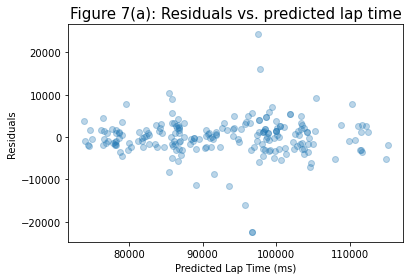

In [214]:
plt.scatter(residuals_full['predicted'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Predicted Lap Time (ms)');plt.ylabel('Residuals')
plt.title('Figure 7(a): Residuals vs. predicted lap time', fontsize=15);plt.show();

Looking at Figure 7(a), we can see majority of values centre around 0 and are mostly random. We do not see any evidence of a banding pattern. 

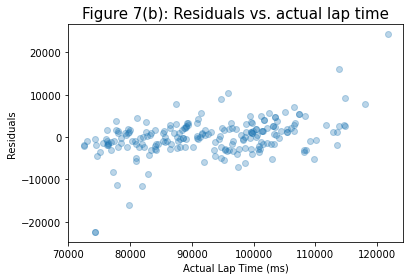

In [215]:
plt.scatter(residuals_full['actual'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Actual Lap Time (ms)');plt.ylabel('Residuals')
plt.title('Figure 7(b): Residuals vs. actual lap time', fontsize=15); plt.show();

In this particular plot, we again see the model underestimating speeds below 85000ms and overestimating about 110000ms.

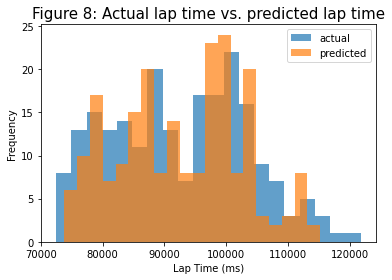

In [216]:
plt.hist(residuals_full['actual'], label='actual', bins=20, alpha=0.7);
plt.hist(residuals_full['predicted'], label='predicted', bins=20, alpha=0.7);
plt.xlabel('Lap Time (ms)');plt.ylabel('Frequency');
plt.title('Figure 8: Actual lap time vs. predicted lap time', fontsize=15);plt.legend(); plt.show();

Here we can see that for the most part, the models predictions are fairly accurate. More often than not, it seems to underestimate.

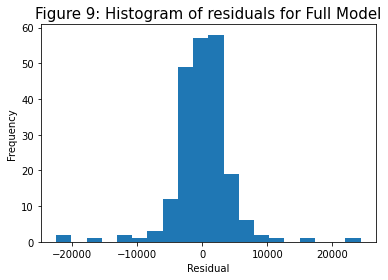

In [217]:
plt.hist(residuals_full['residual'], bins = 20);
plt.xlabel('Residual');plt.ylabel('Frequency');
plt.title('Figure 9: Histogram of residuals for Full Model', fontsize=15);plt.show();

In [218]:
residuals_full.skew(axis = 0, skipna = True)

actual       0.124215
predicted    0.030290
residual    -0.429013
dtype: float64

Residuals are mostly regularly symmetric. Can observe slight left-skewness, confirmed by above. However, we can say with confidence that the normality assumption is not violated. Now we will perform a backwards feature selection to see if we can produce a model with similar performance with less features.

### Backwards Feature Selection

Given the p-value violation (> 0.05) of a few features, namely...
* `temp`
* `track_temp`
* `humidity`
* `air_pressure`

We drop these features, and run a new OLS Regression.

In [219]:
X = df[['rain', 'wind_speed', 'track']]
X = pd.get_dummies(data=X, drop_first=True)
X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
print(model.summary())
print(f"Regression number of terms: {len(model.model.exog_names)}")
print(f"Regression F-distribution p-value: {model.f_pvalue:.4f}")
print(f"Regression R-squared: {model.rsquared:.4f}")
print(f"Regression Adjusted R-squared: {model.rsquared_adj:.4f}")

                            OLS Regression Results                            
Dep. Variable:                lapTime   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     46.19
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           1.01e-63
Time:                        16:57:54   Log-Likelihood:                -2114.1
No. Observations:                 215   AIC:                             4272.
Df Residuals:                     193   BIC:                             4346.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.024e+05   1549

Similar to what we did with the first model, we will plot residuals etc.

In [209]:
residuals_reduced = pd.DataFrame({'actual': df['lapTime'], 'predicted': model.fittedvalues, 'residual': model.resid})
residuals_reduced.sample(n=5, random_state=999)

,actual,predicted,residual
148,101203.545,102292.955806,-1089.410806
191,84167.789,87193.788368,-3025.999368
125,103112.500,100444.665121,2667.834879
68,91556.087,90128.758439,1427.328561
187,95886.722,85259.821766,10626.900234


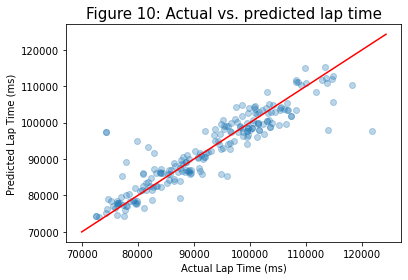

In [210]:
plt.scatter(residuals_reduced['actual'], residuals_reduced['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Lap Time (ms)');plt.ylabel('Predicted Lap Time (ms)');
plt.title('Figure 10: Actual vs. predicted lap time', fontsize=15);plt.show();

New model gives us an adjusted R-Squared value of 0.816. This means that 81.6% of the variance of `lapTime` can be explained with four less variables. However, we are still running into the same problems with the previous model, namely overestimation at shorter tracks and underestimation at longer.

### Reduced Model Diagnostic Checks

As previously, we will generate some scatter plots of residuals as a function of `lapTime`.

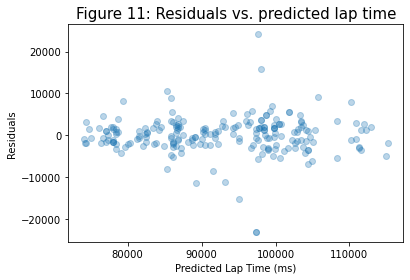

In [211]:
plt.scatter(residuals_reduced['predicted'], residuals_reduced['residual'], alpha=0.3);
plt.xlabel('Predicted Lap Time (ms)');plt.ylabel('Residuals')
plt.title('Figure 11: Residuals vs. predicted lap time', fontsize=15);plt.show();

Results exhibit similar nature to that of initial model. See Figure 7(a).

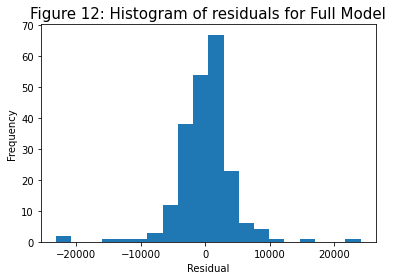

In [212]:
plt.hist(residuals_reduced['residual'], bins = 20);
plt.xlabel('Residual');plt.ylabel('Frequency');
plt.title('Figure 12: Histogram of residuals for Full Model', fontsize=15);plt.show();

In [213]:
residuals_reduced.skew(axis = 0, skipna = True)

actual       0.124215
predicted    0.032963
residual    -0.534603
dtype: float64

Compaired to Figure 9 above, this histogram seems more normally distributed. Looks relatively symmetric around 0 with slight left-skewness.

## Summary & Conclusion <a name="conc">
#### Model Overview
With the use of our numerous independant variables, namely `temp`, `wind_speed` and the likes, we were able to produce a full model with an Adjusted R-Squared value of 0.816. Performing subsequent backwards feature selection, we were able to produce a model with new Adjusted R-Squared of 0.813, with four less variables. The reduced model has 22 terms, and a F-distribution p-value of 0.
Diagnostic checks on our reduced model suggest residuals exhibit acceptable behaviour. With random variance, symmetrical around 0. No banding patterns or significant problems observed.
The final (reduced) models adjusted R-squared of 0.813 is quite high, given the amount of data collected, and problems encountered. This suggests that weather and track data combined are reliable in being able to aid predict lap time performance, more noteably in `rain` and `wind_speed`. This was surprising at first, as it was initially hypothesised that track temps would play a significant role.
The model predicts performance accurately best in mid length tracks, whereas shorter tracks (<85000ms) it tends to overestimate lap time, and on longer tracks (>110000ms), underestimate. These problems may be eliminated with the addition of a greater number of weather and track data points, specifially performance in rainy conditions, as these races were few and far between (33 wet vs 182 dry races).
    
#### Data Exploration
Throughout, clear relationship between particular weather events and track performance was observed, albeit at varying levels.
We can conclude that wet weather has the largest impact on the ability to perform in regards lap times.
Track temperatures have a suprisingly lower affect than predicted, there is potential that in modern racing, both drivers and their teams have learnt to adapt to these slight changes with different tyres and driving techniques (keeping tyre temps ideal). It is however notable that, lower track temps relate to wet weather as rain has shown in our graphs to reduce the overall temperature of the track. Whereas high track temps (beyond a set threshold that we have explored), can actually reduce track performance, as it likely reduces tyre grip as they may degrade faster. 
Finally (for unique weather events), wind speeds have suprisingly more impact than first assumed. Given the assumption that track temperatures were more vital than wind speeds, it is interesting to see that the opposite may be in place. Although clearly not as impactful as wet weather, wind speeds do have a general impact on track performance by showing a pattern where higher wind speeds can actually help improve lap times. This may be due to the improved downforce generated by the additional wind force being excerted on the car, which can help steady the vehicle during higher speeds. However again, a threshold may exist where too high a wind speed may reduce the overall performance (see notable drop offs on wind vs. speed graphs).

#### Furthur study suggested
    
The biggest limitation of our model is that it predicts track specific performance. For furthur studies it is suggested to instead of looking at tracks as a whole, look at track attributes, such as corner types, length etc. This would allow a future model to perform more accurately accross a wider range of tracks and environments, potentially allowing for new track designs to be tested, among other numerous applications.

#### Sources and References
* Monaco circuit info - https://en.wikipedia.org/wiki/Circuit_de_Monaco
* Track temps and their effect on tyres - https://www.prismaelectronics.com/en/blog/effect-track-temperature-tire-degradation
* Weather relationship research - https://sciencing.com/humidity-affect-weather-10033063.html
* Regression Case Study - https://www.featureranking.com/tutorials/statistics-tutorials/regression-case-study/